# Import Libraries

In [19]:
import pandas as pd
import dask.dataframe as dd
from dask_ml.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
import joblib
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import tkinter as tk
from tkinter import messagebox
import numpy as np

# Data Preprocessing

In [20]:
# Load the dataset with Dask
normal_traffic_df = dd.read_csv("normal_dataset.csv")
malicious_traffic_df = dd.read_csv("malicious_dataset.csv")

# Add labels
normal_traffic_df['label'] = 'normal'
malicious_traffic_df['label'] = 'malicious'

# Concatenate the datasets
combined_df = dd.concat([normal_traffic_df, malicious_traffic_df])

# Shuffle the dataset
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Change label to 'scan' for all malicious activities
combined_df['label'] = combined_df['label'].apply(lambda x: 'scan' if x != 'normal' else x, meta=('x', 'str'))

# Handle missing values
combined_df = combined_df.dropna(subset=['tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset'])

# Convert hexadecimal columns to float
hex_columns = ["tcp.flags", "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset"]
for col in hex_columns:
    combined_df[col] = combined_df[col].apply(lambda x: float(int(x, 16)) if isinstance(x, str) else float(x), meta=('x', 'float'))

# Convert to Pandas DataFrame
data_df = combined_df.compute()

# Check for unique values in 'label'
print("Unique labels before encoding:", data_df['label'].unique())

# Encode labels
label_encoder = LabelEncoder()
data_df['label'] = label_encoder.fit_transform(data_df['label'])

# Check for unique values in 'label' after encoding
print("Unique labels after encoding:", data_df['label'].unique())

# Select relevant features
features_to_keep = ["tcp.srcport", "tcp.dstport", "tcp.flags", "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset", "label"]
data_df = data_df[features_to_keep]

# Remove duplicates
data_df = data_df.drop_duplicates()

# Define features and target
X = data_df.drop("label", axis=1)
y = data_df["label"]

# Check class distribution before and after shuffling
print("Class distribution before resampling:")
print(y.value_counts())

# Handle class imbalance using undersampling if needed
if len(y.unique()) > 1:
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
else:
    X_resampled, y_resampled = X, y

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts())

# Split the dataset into training and testing sets with stratification using sklearn
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42, stratify=y_resampled)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Unique labels before encoding: ['normal' 'scan']
Unique labels after encoding: [0 1]
Class distribution before resampling:
label
1    161802
0     27452
Name: count, dtype: int64
Class distribution after resampling:
label
0    27452
1    27452
Name: count, dtype: int64


# Model Training and Evaluation

In [21]:
# Train and evaluate a Decision Tree classifier
tree_classifier = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10)
tree_classifier.fit(X_train, y_train)
tree_predictions = tree_classifier.predict(X_test)
tree_accuracy = accuracy_score(y_test, tree_predictions)
tree_precision = precision_score(y_test, tree_predictions, average="weighted")
tree_recall = recall_score(y_test, tree_predictions, average="weighted")
tree_f1 = f1_score(y_test, tree_predictions, average="weighted")
print("Decision Tree Accuracy:", tree_accuracy)
print("Decision Tree Precision:", tree_precision)
print("Decision Tree Recall:", tree_recall)
print("Decision Tree F1-Score:", tree_f1)

# Train and evaluate a Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, average="weighted")
nb_recall = recall_score(y_test, nb_predictions, average="weighted")
nb_f1 = f1_score(y_test, nb_predictions, average="weighted")
print("Naive Bayes Accuracy:", nb_accuracy)
print("Naive Bayes Precision:", nb_precision)
print("Naive Bayes Recall:", nb_recall)
print("Naive Bayes F1-Score:", nb_f1)

# Train and evaluate a Random Forest classifier
rf_params = {'n_estimators': [50, 100], 'max_depth': [None, 10, 20]}
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=rf_params, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1, verbose=2, error_score='raise')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
rf_predictions = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average="weighted")
rf_recall = recall_score(y_test, rf_predictions, average="weighted")
rf_f1 = f1_score(y_test, rf_predictions, average="weighted")
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision)
print("Random Forest Recall:", rf_recall)
print("Random Forest F1-Score:", rf_f1)

# Train and evaluate an AdaBoost classifier
ab_params = {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1, 1.0]}
grid_ab = GridSearchCV(AdaBoostClassifier(), param_grid=ab_params, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1, verbose=2, error_score='raise')
try:
    grid_ab.fit(X_train, y_train)
    best_ab = grid_ab.best_estimator_
    ab_predictions = best_ab.predict(X_test)
    ab_accuracy = accuracy_score(y_test, ab_predictions)
    ab_precision = precision_score(y_test, ab_predictions, average="weighted")
    ab_recall = recall_score(y_test, ab_predictions, average="weighted")
    ab_f1 = f1_score(y_test, ab_predictions, average="weighted")
    print("AdaBoost Accuracy:", ab_accuracy)
    print("AdaBoost Precision:", ab_precision)
    print("AdaBoost Recall:", ab_recall)
    print("AdaBoost F1-Score:", ab_f1)
except ValueError as e:
    print(f"Skipping AdaBoost: {e}")

# Train and evaluate an Extra Trees classifier
et_params = {'n_estimators': [50], 'criterion': ['gini'], 'min_samples_split': [2], 'min_samples_leaf': [1], 'max_features': ['sqrt']}
grid_et = GridSearchCV(ExtraTreesClassifier(), param_grid=et_params, cv=StratifiedKFold(n_splits=3), scoring='accuracy', n_jobs=-1, verbose=2, error_score='raise')
try:
    grid_et.fit(X_train, y_train)
    best_et = grid_et.best_estimator_
    et_predictions = best_et.predict(X_test)
    et_accuracy = accuracy_score(y_test, et_predictions)
    et_precision = precision_score(y_test, et_predictions, average="weighted")
    et_recall = recall_score(y_test, et_predictions, average="weighted")
    et_f1 = f1_score(y_test, et_predictions, average="weighted")
    print("Extra Trees Accuracy:", et_accuracy)
    print("Extra Trees Precision:", et_precision)
    print("Extra Trees Recall:", et_recall)
    print("Extra Trees F1-Score:", et_f1)
except ValueError as e:
    print(f"Skipping Extra Trees: {e}")
    
    # Evaluate models and find the best one
models = {
    'Decision Tree': tree_classifier,
    'Naive Bayes': nb_classifier,
    'Random Forest': best_rf,
    'AdaBoost': best_ab if 'best_ab' in locals() else None,
    'Extra Trees': best_et if 'best_et' in locals() else None
}

best_model = None
best_score = 0
for name, model in models.items():
    if model:
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        if accuracy > best_score:
            best_score = accuracy
            best_model = model
            best_model_name = name

print(f"Best Model: {best_model_name} with Accuracy: {best_score}")


Decision Tree Accuracy: 0.7949247207382224
Decision Tree Precision: 0.7959215014813201
Decision Tree Recall: 0.7949247207382224
Decision Tree F1-Score: 0.7947518815130896
Naive Bayes Accuracy: 0.7003399708596406
Naive Bayes Precision: 0.7171578859630103
Naive Bayes Recall: 0.7003399708596406
Naive Bayes F1-Score: 0.6944235863831922
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Random Forest Accuracy: 0.958596406022341
Random Forest Precision: 0.9586905627038292
Random Forest Recall: 0.958596406022341
Random Forest F1-Score: 0.9585942811557109
Fitting 3 folds for each of 6 candidates, totalling 18 fits


C:\Users\dilki\AppData\Roaming\Python\Python312\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost Accuracy: 0.8916949975716367
AdaBoost Precision: 0.8926586108505474
AdaBoost Recall: 0.8916949975716367
AdaBoost F1-Score: 0.8916285096580502
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Extra Trees Accuracy: 0.9486401165614375
Extra Trees Precision: 0.9486594038695668
Extra Trees Recall: 0.9486401165614375
Extra Trees F1-Score: 0.9486395645811743
Best Model: Random Forest with Accuracy: 0.958596406022341


# Save the final Model

In [22]:
# Save the best model and scaler
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'encoder.pkl')

print("Best model saved.")

Best model saved.


# Sending Email

In [23]:
# Function to send email
def send_email(subject, body):
    from_email = 'idssolutions123@gmail.com'
    password = 'yyjwyodyxyyzcyii'
    to_email = 'alexandercs2018002@gmail.com'
    
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject
    
    msg.attach(MIMEText(body, 'plain'))
    
    try:
        # Establish a secure session with the server
        server = smtplib.SMTP_SSL('smtp.gmail.com', 465)
        server.ehlo()
        
        # Login to the server
        server.login(from_email, password)
        
        # Send the email
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        print("Email sent successfully.")
    except Exception as e:
        print(f"Failed to send email. Error: {str(e)}")

# Create GUI

In [24]:
# GUI for inputting data and predicting port scanning
class PortScanningApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Port Scanning Detection")
        self.root.geometry("400x600")

        # Define feature names
        self.feature_names Create GUI¶= ['tcp.srcport', 'tcp.dstport', 'tcp.flags', 'tcp.flags.syn', 'tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.reset']

        # Mapping from label indices to port scan descriptions
        self.scan_descriptions = {
            0: "SYN Scan: The most popular scan type, where the attacker sends a SYN packet to initiate a connection and then waits for a SYN-ACK response to determine if the port is open.",
            1: "ACK Scan: Used to map out firewall rules, the attacker sends ACK packets to various ports and interprets the response to understand the firewall's behavior.",
            2: "FIN Scan: The attacker sends a FIN packet, which is used to close a connection. If a response is received, it indicates the port is closed.",
            3: "NULL Scan: No flags are set in the TCP header. This type of scan is designed to exploit TCP/IP stack differences in various operating systems.",
            4: "Xmas Scan: All flags (FIN, URG, and PUSH) are set. Like the NULL scan, it relies on variations in how different OSes handle the packet.",
            5: "Connect Scan: Completes the three-way handshake (SYN, SYN-ACK, ACK) with the target, providing the most reliable results but also the most detectable."
        }

        # Create input fields for features
        self.entries = {}
        for i, column in enumerate(self.feature_names):
            label = tk.Label(root, text=column)
            label.grid(row=i, column=0, padx=10, pady=5)
            entry = tk.Entry(root)
            entry.grid(row=i, column=1, padx=10, pady=5)
            self.entries[column] = entry

        # Predict button
        predict_button = tk.Button(root, text="Predict", command=self.predict)
        predict_button.grid(row=len(self.feature_names), column=0, columnspan=2, pady=10)

    def predict(self):
        # Extract input values
        input_data = []
        for column, entry in self.entries.items():
            value = entry.get()
            if value:
                try:
                    input_data.append(float(value))
                except ValueError:
                    messagebox.showwarning("Input Error", f"Please enter a numeric value for {column}")
                    return
            else:
                messagebox.showwarning("Input Error", f"Please enter a value for {column}")
                return

        # Convert to numpy array and reshape
        input_data = np.array(input_data).reshape(1, -1)
        standardized_input_data = scaler.transform(input_data)

        # Predict using the trained model
        prediction = best_model.predict(standardized_input_data)
        label_index = prediction[0]
        label = label_encoder.inverse_transform([label_index])[0]

        # Show the prediction result
        messagebox.showinfo("Prediction Result", f"The input data is predicted as: {label}")

        # Send an email if the prediction is 'scan'
        if label == 'scan':
            description = self.scan_descriptions.get(label_index, "Unknown Scan Type")
            subject = "Port Scan Detected"
            original_input_data = scaler.inverse_transform(standardized_input_data).flatten()
            body = (f"A port scan has been detected with the following details:\n\n"
                    f"{dict(zip(self.feature_names, original_input_data))}\n\n"
                    f"Type of Port Scan: {description}")
            send_email(subject, body)

# Initialize the application
root = tk.Tk()
app = PortScanningApp(root)
root.mainloop()

Data Visualization

C:\Users\dilki\AppData\Local\Temp\ipykernel_22568\4027199513.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='label', palette='viridis')


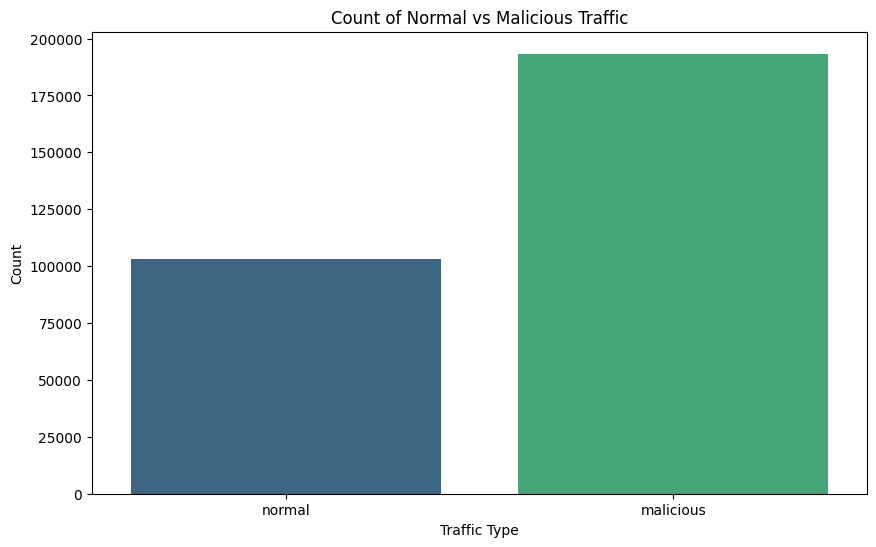

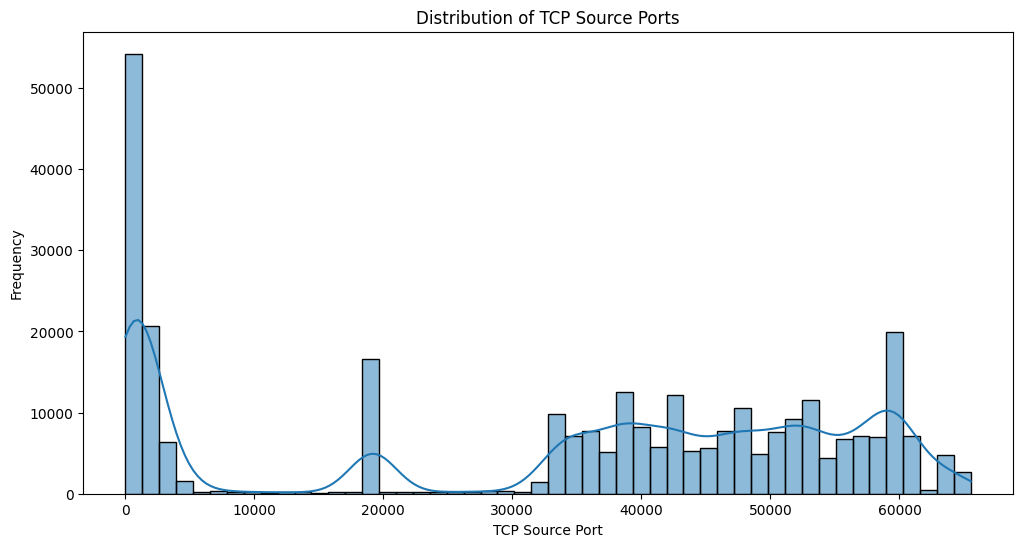

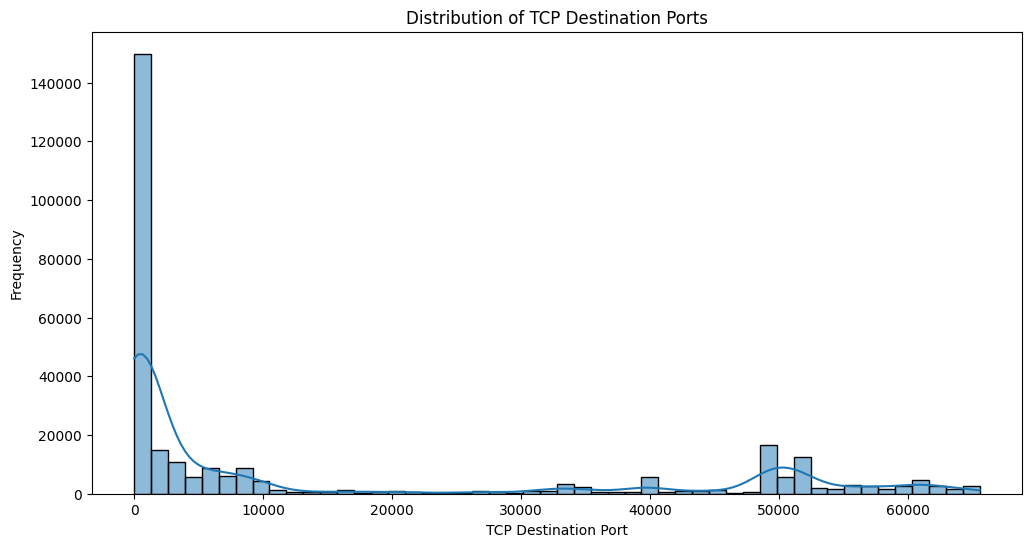

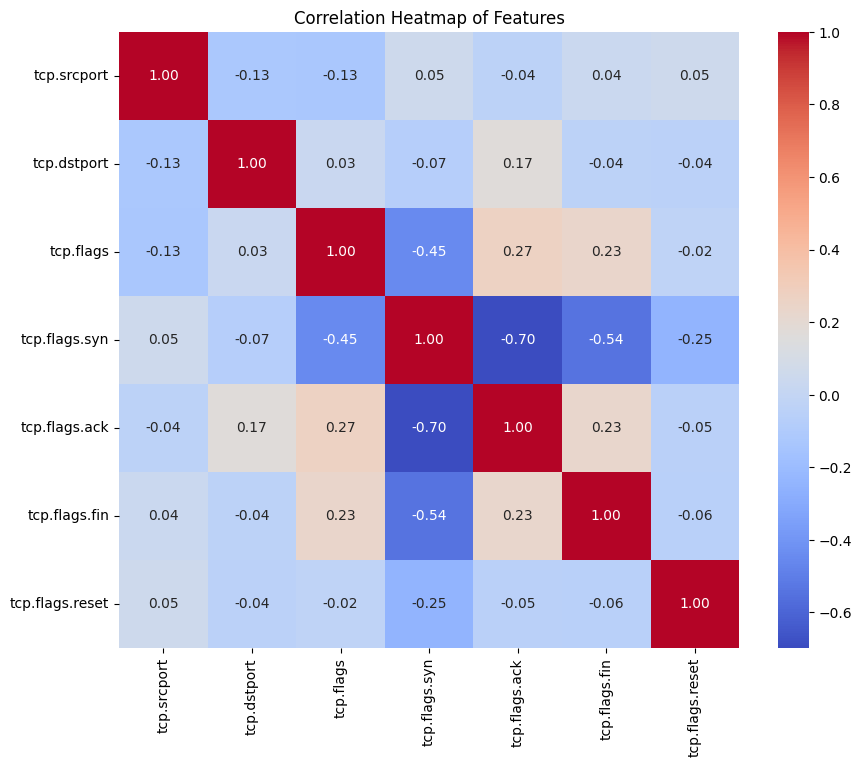

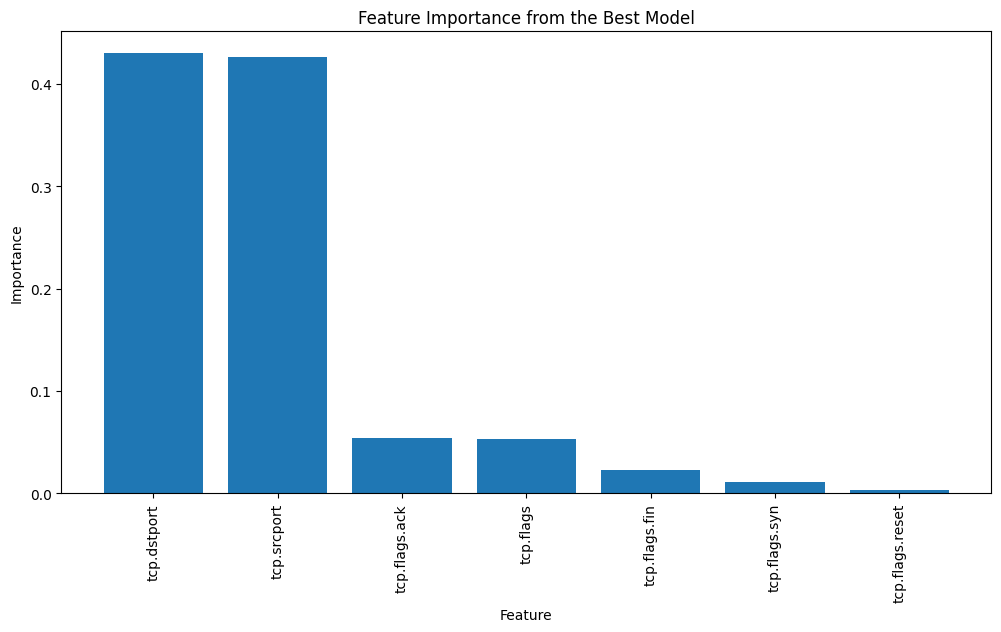

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the datasets
normal_traffic_df = pd.read_csv("normal_dataset.csv")
malicious_traffic_df = pd.read_csv("malicious_dataset.csv")

# Add labels
normal_traffic_df['label'] = 'normal'
malicious_traffic_df['label'] = 'malicious'

# Concatenate the datasets
combined_df = pd.concat([normal_traffic_df, malicious_traffic_df])

# Create the count plot
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='label', palette='viridis')
plt.title('Count of Normal vs Malicious Traffic')
plt.xlabel('Traffic Type')
plt.ylabel('Count')
plt.show()
# Plot the distribution of TCP source ports
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['tcp.srcport'], bins=50, kde=True)
plt.title('Distribution of TCP Source Ports')
plt.xlabel('TCP Source Port')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of TCP destination ports
plt.figure(figsize=(12, 6))
sns.histplot(combined_df['tcp.dstport'], bins=50, kde=True)
plt.title('Distribution of TCP Destination Ports')
plt.xlabel('TCP Destination Port')
plt.ylabel('Frequency')
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data_df is your DataFrame containing the features
# Select only the relevant feature columns for the correlation heatmap
feature_columns = ["tcp.srcport", "tcp.dstport", "tcp.flags", "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset"]
feature_df = data_df[feature_columns]

# Compute the correlation matrix
correlation_matrix = feature_df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model is the trained model and the feature names are stored in feature_names
feature_names = ["tcp.srcport", "tcp.dstport", "tcp.flags", "tcp.flags.syn", "tcp.flags.ack", "tcp.flags.fin", "tcp.flags.reset"]

if hasattr(best_model, "feature_importances_"):
    # Get feature importances from the best model
    feature_importances = best_model.feature_importances_

    # Sort the feature importances in descending order
    indices = np.argsort(feature_importances)[::-1]

    # Rearrange feature names so they match the sorted feature importances
    sorted_feature_names = [feature_names[i] for i in indices]

    # Plot the feature importances
    plt.figure(figsize=(12, 6))
    plt.title("Feature Importance from the Best Model")
    plt.bar(range(len(feature_names)), feature_importances[indices], align="center")
    plt.xticks(range(len(feature_names)), sorted_feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.show()
else:
    print(f"The best model of type {type(best_model)} does not support feature importances.")
